# **Question Answering with Transformers on CoQA**

### Natural Language Processing

In [ ]:
!pip install transformers==4.25.1
!pip install datasets
!pip install evaluate

In [ ]:
from google.colab import drive, files

drive_path_model = '/content/gdrive/MyDrive/AssignmentNLP/'

drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
# Importing libraries

import os
import json
import pandas as pd
import random
import numpy as np
import datasets
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from functools import partial
from tensorflow import keras
from sklearn.metrics import f1_score
from keras.callbacks import ModelCheckpoint

from transformers import AutoTokenizer, EncoderDecoderModel, Seq2SeqTrainer, Seq2SeqTrainingArguments

import torch

!wget https://raw.githubusercontent.com/allenai/allennlp-models/main/allennlp_models/rc/tools/squad.py

import squad

In [ ]:
def set_reproducibility(seed):
    ''' Sets a given seed for reproducibility'''
    
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'

In [ ]:
# seeds: 42, 1337, 2022

seed = 42
set_reproducibility(seed)

### Downloading CoQA dataset

In [ ]:
import os
import urllib.request
from tqdm import tqdm

class DownloadProgressBar(tqdm):
    def update_to(self, b=1, bsize=1, tsize=None):
        if tsize is not None:
            self.total = tsize
        self.update(b * bsize - self.n)
        
def download_url(url, output_path):
    with DownloadProgressBar(unit='B', unit_scale=True,
                             miniters=1, desc=url.split('/')[-1]) as t:
        urllib.request.urlretrieve(url, filename=output_path, reporthook=t.update_to)

def download_data(data_path, url_path, suffix):    
    if not os.path.exists(data_path):
        os.makedirs(data_path)
        
    data_path = os.path.join(data_path, f'{suffix}.json')

    if not os.path.exists(data_path):
        print(f"Downloading CoQA {suffix} data split... (it may take a while)")
        download_url(url=url_path, output_path=data_path)
        print("Download completed!")

In [ ]:
# Train data
train_url = "https://nlp.stanford.edu/data/coqa/coqa-train-v1.0.json"
download_data(data_path='coqa', url_path=train_url, suffix='train')

# Test data
test_url = "https://nlp.stanford.edu/data/coqa/coqa-dev-v1.0.json"
download_data(data_path='coqa', url_path=test_url, suffix='test') 

coqa-train-v1.0.json: 49.0MB [00:05, 8.23MB/s]                            


Download completed!


coqa-dev-v1.0.json: 9.09MB [00:01, 7.25MB/s]                            

Download completed!


In [ ]:
# JSON file paths
train_file = 'coqa/train.json'
test_file = 'coqa/test.json'

# JSON files to Pandas Dataframe object
coqa_train = pd.read_json(train_file)
coqa_test = pd.read_json(test_file)

The following function allows to build the new dataframe with the useful features for question answering:

In [ ]:
def build_dataframe(data):
  '''
  Builds the dataframe by creating one QA pair per row, each one with 
  its ID, source, story and rational

  :param data: Pandas Dataframe object data 

  :return pd.DataFrame: the new built dataframe 
  '''

  # drop irrelevant column
  data = data.drop('version', axis=1)

  cols = ['doc_id', 'source', 'story', 'question', 'answer', 'rational']
  df_list = []

  for index, row in data.iterrows():
    for i in range(len(row['data']['questions'])):
        data_list = []
        data_list.append(index+1)
        data_list.append(row['data']['source'])

        data_list.append(row['data']['story'].replace('\n', '').strip())
        data_list.append(row['data']['questions'][i]['input_text'])
        data_list.append(row['data']['answers'][i]['input_text'])
        data_list.append(row['data']['answers'][i]['span_text'])
        
        df_list.append(data_list)

  return pd.DataFrame(df_list, columns=cols) 

In [ ]:
# build dataframe for both train and test data
df_train = build_dataframe(coqa_train)
df_test = build_dataframe(coqa_test)

print('Training set shape:', df_train.shape)
print('Test set shape:', df_test.shape)

Training set shape: (108647, 6)
Test set shape: (7983, 6)


In [ ]:
df_train

,doc_id,source,story,question,answer,rational
0,1,wikipedia,"The Vatican Apostolic Library (), more commonl...",When was the Vat formally opened?,It was formally established in 1475,Formally established in 1475
1,1,wikipedia,"The Vatican Apostolic Library (), more commonl...",what is the library for?,research,he Vatican Library is a research library
2,1,wikipedia,"The Vatican Apostolic Library (), more commonl...",for what subjects?,"history, and law",Vatican Library is a research library for hist...
3,1,wikipedia,"The Vatican Apostolic Library (), more commonl...",and?,"philosophy, science and theology",Vatican Library is a research library for hist...
4,1,wikipedia,"The Vatican Apostolic Library (), more commonl...",what was started in 2014?,a project,"March 2014, the Vatican Library began an initi..."
...,...,...,...,...,...,...
108642,7199,cnn,(CNN) -- Cristiano Ronaldo provided the perfec...,Who was a sub?,Xabi Alonso,substitute Xabi Alonso
108643,7199,cnn,(CNN) -- Cristiano Ronaldo provided the perfec...,Was it his first game this year?,Yes,Xabi Alonso made his first appearance of the ...
108644,7199,cnn,(CNN) -- Cristiano Ronaldo provided the perfec...,What position did the team reach?,third,Real moved up to third in the table
108645,7199,cnn,(CNN) -- Cristiano Ronaldo provided the perfec...,Who was ahead of them?,Barca.,six points behind Barca.


In [ ]:
df_test

,doc_id,source,story,question,answer,rational
0,1,mctest,"Once upon a time, in a barn near a farm house,...",What color was Cotton?,white,a little white kitten named Cotton
1,1,mctest,"Once upon a time, in a barn near a farm house,...",Where did she live?,in a barn,"in a barn near a farm house, there lived a lit..."
2,1,mctest,"Once upon a time, in a barn near a farm house,...",Did she live alone?,no,Cotton wasn't alone
3,1,mctest,"Once upon a time, in a barn near a farm house,...",Who did she live with?,with her mommy and 5 sisters,with her mommy and 5 other sisters
4,1,mctest,"Once upon a time, in a barn near a farm house,...",What color were her sisters?,orange and white,her sisters were all orange with beautiful whi...
...,...,...,...,...,...,...
7978,500,wikipedia,"Las Vegas (, Spanish for ""The Meadows""), offic...","where does the nickname ""Sin City"" come from?",The city's tolerance for numerous forms of adu...,The city's tolerance for numerous forms of adu...
7979,500,wikipedia,"Las Vegas (, Spanish for ""The Meadows""), offic...",Which state is it in?,Nevada,"Vegas, is the 28th-most populated city in the ..."
7980,500,wikipedia,"Las Vegas (, Spanish for ""The Meadows""), offic...",Is it located in a desert?,Yes,within the greater Mojave Desert
7981,500,wikipedia,"Las Vegas (, Spanish for ""The Meadows""), offic...",what is the name of the desert?,Mojave Desert.,Mojave Desert.


### [Task 1] Remove unanswerable QA pairs

In [ ]:
# locate unanswerable QA pairs (i.e. answer is unknown)
unanswerable_train = df_train.loc[df_train['answer'] == 'unknown'].index
unanswerable_test = df_test.loc[df_test['answer'] == 'unknown'].index

print('The number of unanswerable questions in the training set is: ', len(unanswerable_train))
print('The number of unanswerable questions in the test set is: ', len(unanswerable_test))

The number of unanswerable questions in the training set is:  1371
The number of unanswerable questions in the test set is:  66


In [ ]:
# remove unanswerable QA pairs both on training and test data
df_train.drop(unanswerable_train, inplace = True)
df_test.drop(unanswerable_test, inplace = True)

print(f'After removing the unanswerable QA pairs, the training set has a number of rows of {df_train.shape[0]}')
print(f'After removing the unanswerable QA pairs, the test set has a number of rows of {df_test.shape[0]}')

After removing the unanswerable QA pairs, the training set has a number of rows of 107276
After removing the unanswerable QA pairs, the test set has a number of rows of 7917


### Exploratory Data Analysis

We now explore a random example of a story, question and answer of the training dataset

In [ ]:
df_train['story'][1000]

'Jamie Oliver has been invited by Gordon Brown to prepare a banquet at No.10 for President Barack Obama and other leaders of the G20, offering a cut-price menu to reflect times when trade and industry are far from prosperous and the rate of employment is decreasing. Downing Street sources say Oliver, the well-known chef, will cook using "honest high-street products" and avoid expensive or "fancy" ingredients. The prime minister is trying to avoid a repeat of the embarrassment last year when he sat down to an 18-course banquet at a Japanese summit to discuss world food shortages. Obama, President Nicolas Sarkozy of France, Chancellor Angela Merkel of Germany and other leaders will be served by apprentices from Fifteen, the London restaurant Oliver founded to help train young people in poverty in order to make a living by mastering a skill. Brown wants the dinner to reflect the emphasis of the London summit, which he hopes will lead to an agreement to lift the world out of recession."To 

In [ ]:
df_train['question'][1000]

'Who was the French president?'

In [ ]:
df_train['answer'][1000]

'Nicolas Sarkozy'

Plotting the distribution of the different sources (wikipedia, cnn, gutenberg, race, mctest)

<Axes: xlabel='source', ylabel='count'>

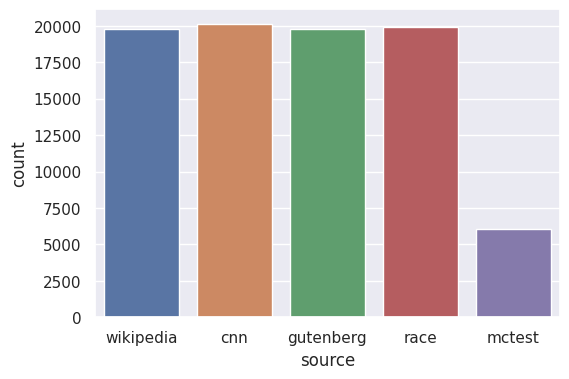

In [ ]:
plt.figure(figsize=(6,4))
sns.countplot(x='source', data=df_train)

We will now plot the distribution of the story words in the training set and show itsnstatistics like count, mean, min, max values and 99% percentile.

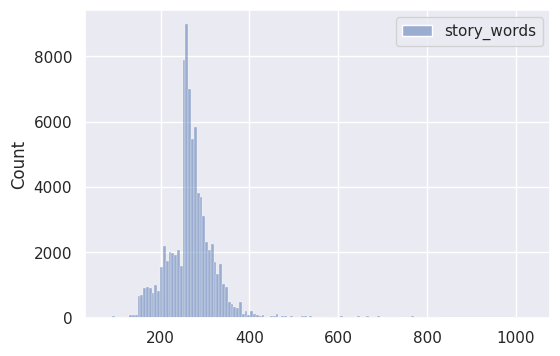

In [ ]:
df_story_words = pd.DataFrame({'story_words': df_train['story'].str.split().apply(len)})

sns.histplot(df_story_words, bins=150, kde=False)
sns.set(rc={'figure.figsize':(6,4)})

plt.grid(True)
plt.show()

In [ ]:
df_story_words.describe(percentiles=[.99])

,story_words
count,107276.000000
mean,270.867594
std,62.913194
min,70.000000
50%,266.000000
99%,515.000000
max,1030.000000


The results show that the max length of the story in the training set is 1030, but the 99 percentile is 515.

Now we will repeat the same process to analyze the statistics of the questions.

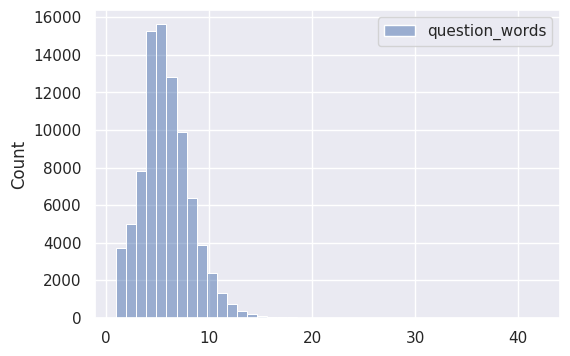

In [ ]:
question_words = df_train['question'].str.split().apply(len)
df_question_words = pd.DataFrame({'question_words': question_words})

sns.histplot(df_question_words, bins=int(question_words.max()), kde=False)
sns.set(rc={'figure.figsize':(6,4)})

plt.grid(True)
plt.show()

In [ ]:
df_question_words.describe(percentiles=[.99])

,question_words
count,107276.000000
mean,5.457511
std,2.472835
min,1.000000
50%,5.000000
99%,12.000000
max,42.000000


The plot and the statistical values of the answers above show that the max length is 42, while the 99 percentile is 12.

The max input length of the encoder for the Bert model is 512, which is able to fit almost all the story and question's lengths. Therefore we set 512 as the input length for the models, as only a minimal part of the total dialogues would be truncated.

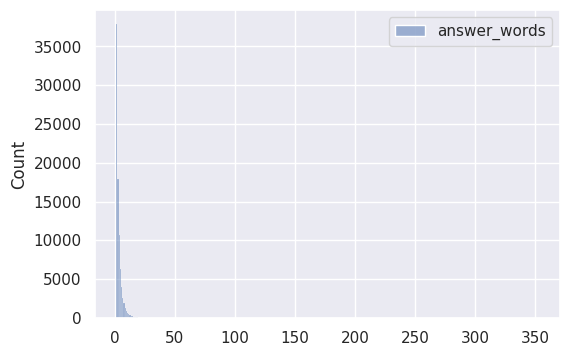

In [ ]:
answer_words = df_train['answer'].str.split().apply(len)
df_answer_words = pd.DataFrame({'answer_words': answer_words})

sns.histplot(df_answer_words, bins=int(answer_words.max()), kde=False)
sns.set(rc={'figure.figsize':(6,4)})

plt.grid(True)
plt.show()

In [ ]:
df_answer_words.describe(percentiles=[.99])

,answer_words
count,107276.000000
mean,2.675090
std,2.929003
min,1.000000
50%,2.000000
99%,13.000000
max,353.000000


Considering the 99 percentile of the answers, the max decoder length was set to 16.

We now define a function which adds dialogue history to each document in the dataframe

In [ ]:
def add_dialogue_history(df):
    '''
    Computes the dialogue history for each document in the DataFrame and appends it 
    to each row as a new column.

    :param df: The DataFrame for which to compute the dialogue history

    :return: A new DataFrame with the added dialogue history column
    '''

    # group the df by doc_id and extract the QA pairs for each group
    doc_ids = df['doc_id'].unique()
    dialogues = []

    for id in doc_ids:
        group = df.loc[df['doc_id'] == id]
        dialogues.append(group[['question', 'answer']].to_numpy())

    # list of dialogue histories
    history_list = []
    for dialogue in dialogues:
        for i in range(len(dialogue)):
            # append each dialogue up to each row
            history_list.append(dialogue[:i])

    # Create a copy of the original df and add the dialogue history as a new column
    df_history = df.copy()
    df_history['history'] = history_list

    return df_history

In [ ]:
# add history column to both training and test sets
df_train = add_dialogue_history(df_train)
df_test  = add_dialogue_history(df_test)

In [ ]:
df_test.head()

,doc_id,source,story,question,answer,rational,history
0,1,mctest,"Once upon a time, in a barn near a farm house,...",What color was Cotton?,white,a little white kitten named Cotton,[]
1,1,mctest,"Once upon a time, in a barn near a farm house,...",Where did she live?,in a barn,"in a barn near a farm house, there lived a lit...","[[What color was Cotton?, white]]"
2,1,mctest,"Once upon a time, in a barn near a farm house,...",Did she live alone?,no,Cotton wasn't alone,"[[What color was Cotton?, white], [Where did s..."
3,1,mctest,"Once upon a time, in a barn near a farm house,...",Who did she live with?,with her mommy and 5 sisters,with her mommy and 5 other sisters,"[[What color was Cotton?, white], [Where did s..."
4,1,mctest,"Once upon a time, in a barn near a farm house,...",What color were her sisters?,orange and white,her sisters were all orange with beautiful whi...,"[[What color was Cotton?, white], [Where did s..."


### [Task 2] Train, Validation and Test splits

We will split the dataset at dialogue level, in such a way that a dialogue appears in one split only. The split is performed in this way: the original training set is divided into training (80%) and validation (20%) sets, while the test set is the one which was previously defined.

In [ ]:
def train_validation_split(df, train_size):
  '''
  Splits a dataframe into training and validation set at dialogue level

  :param df: Dataframe to split
  :param train_size: Ratio of the dialogue in the training set

  :return:
    - split_df_train: Dataframe containing all the documents of the training set
    - df_val : Dataframe containing all the documents of the validation set
  '''
  # get unique dialogues and shuffle them
  dialogues = df['doc_id'].unique()
  np.random.shuffle(dialogues)

  # calculate the index where the split between training and val should occur
  sep = int(train_size * len(dialogues))

  # select the dialogues up to the sep index for training and val sets
  train_dialogues, val_dialogues = dialogues[:sep], dialogues[sep:]

  # select all rows from the input df that belong to the dialogues in the sets
  df_train = df.loc[df['doc_id'].isin(train_dialogues)]
  df_val = df.loc[df['doc_id'].isin(val_dialogues)]

  return df_train, df_val

In [ ]:
df_train, df_val = train_validation_split(df_train, 0.8)

print("Training set shape: ", df_train.shape)
print("Validation set shape:  ", df_val.shape)
print("Test set shape:  ", df_test.shape)

Training set shape:  (85683, 7)
Validation set shape:   (21593, 7)
Test set shape:   (7917, 7)


### [Task 3] Model definition

Definition of two models:

*   BERTTiny (bert-tiny)
*   DistilRoBERTa (distilroberta-base)



In [ ]:
# Models
bert_tiny = 'prajjwal1/bert-tiny'
distilroberta = 'distilroberta-base'

# Max input tokens of the encoder
ENCODER_MAX_LENGTH = 512

# Max output tokens of the decoder
DECODER_MAX_LENGTH = 16

In [ ]:
# Loading the tokenizers for the two models
bert_tiny_tokenizer = AutoTokenizer.from_pretrained(bert_tiny)
distilroberta_tokenizer = AutoTokenizer.from_pretrained(distilroberta)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
def load_model(model_name, tokenizer):
  '''
  Loads an encoder-decoder pre-trained model and corresponding tokenizer

  :param model_name: name of the model to load
  :param tokenizer: the model tokenizer to load

  :return:
    model: pretrained encoder-decoder transformer model

  '''
  model = EncoderDecoderModel.from_encoder_decoder_pretrained(model_name, 
                                                              model_name).to(device) 

  model.config.decoder_start_token_id = tokenizer.cls_token_id
  model.config.eos_token_id = tokenizer.sep_token_id
  model.config.pad_token_id = tokenizer.pad_token_id
  model.config.max_new_tokens = DECODER_MAX_LENGTH
  model.config.vocab_size = model.config.decoder.vocab_size
  model.config.early_stopping = True
  model.config.no_repeat_ngram_size = 3
  model.config.num_beams = 4

  return model

### [Task 4] Question generation with text passage $P$ and question $Q$

In [ ]:
def generate_answer(model, tokenizer, story, question):
  '''
  Generates an answer given a question and a story.

  :param model: the model used to generate the answer
  :param tokenizer: the tokenizer of the model
  :param story: string representing the story of the question
  :param question: string representing the question

  :return:
    - the generated answer

  '''
  # tokenize the input
  inputs = tokenizer(question, story, padding="max_length", truncation="only_second",
                     max_length=ENCODER_MAX_LENGTH)

  # generate answer tokens through beam search
  outputs = model.generate(input_ids=torch.as_tensor([inputs.input_ids]).to(device),
                           attention_mask=torch.as_tensor([inputs.attention_mask]).to(device),
                           max_length=DECODER_MAX_LENGTH)
  
  # decode the answer 
  generated = tokenizer.decode(outputs.tolist()[0], skip_special_tokens=True)
  
  return generated

### [Task 5] Question generation with text passage $P$, question $Q$ and dialogue history $H$

In [1]:
def generate_answer_with_history(model, tokenizer, story, question, history):
  '''
  Generates an answer given a story and question and 
  taking into account the QA history.

  :param model: the model used to generate the answer
  :param tokenizer: the tokenizer of the model
  :param story: string representing the story of the question
  :param question: string representing the question
  :param history: list represening past questions and answers on the same story

  :return:
    - the generated answer

  '''

  # history string for QAs with SEP token
  str_history = tokenizer.sep_token.join([f' {question} {tokenizer.sep_token} {answer} ' for question, answer in history])

  # story and history tokenized                
  inputs = tokenizer(question, f' {story} {tokenizer.sep_token} {str_history} ', padding="max_length", truncation="only_second", max_length=ENCODER_MAX_LENGTH)
  
  # generate answer tokens through beam search
  outputs = model.generate(input_ids=torch.as_tensor([inputs.input_ids]).to(device),
                           attention_mask=torch.as_tensor([inputs.attention_mask]).to(device),
                           max_length=DECODER_MAX_LENGTH)
   
  # decode the answer 
  generated = tokenizer.decode(outputs.tolist()[0], skip_special_tokens=True)

  return generated

###[Task 6] Train and evaluation

### Tokenization

In [ ]:
BATCH_SIZE = 32

In [ ]:
def process_data_to_model_inputs(batch, tokenizer, hist = False):
  '''
  Tokenizes a batch of data

  :param batch: the batch of data that will be tokenized
  :param tokenizer: the model tokenizer that will be used to tokenize the batch
  :param hist: a boolean to check if the QA history needs to be taken in account

  :return batch: batch of data tokenized
  '''

  if hist:
    # concatenate the strings in batch['story'] and batch['history']
    story = [s + h for s, h in zip(batch['story'], batch['history'])]
  else:
    story = batch['story']

  # the input is question + story (+ history)
  inputs = tokenizer(batch['question'], story, padding="max_length", truncation="only_second", max_length=ENCODER_MAX_LENGTH)
  
  # the output is the answer
  outputs = tokenizer(batch['answer'], padding="max_length", truncation=True, max_length=DECODER_MAX_LENGTH)
  
  batch['input_ids'] = inputs.input_ids
  batch['attention_mask'] = inputs.attention_mask
  batch['labels'] = outputs.input_ids.copy()
  
  return batch

In [ ]:
def preprocess_dataset(df, tokenizer, hist=False):
    '''
    Preprocesses the dataset by performing tokenization using the given tokenizer

    param df: the input DataFrame to be tokenized
    param tokenizer: the tokenizer to be used for tokenization
    param hist: boolean to include QAs history in the input

    :return df_tok: a tokenized dataset in the form of a `datasets.Dataset` object
    '''
    df_tok = df.copy()
    
    # convert the history column to a string
    str_history = []
    for history in df_tok['history']:
        hist_string = tokenizer.sep_token.join([f' {question} {tokenizer.sep_token} {answer} ' for question, answer in history])
        str_history.append(hist_string)

    df_tok['history'] = str_history
    
    # convert the df to a HuggingFace dataset
    df_tok = datasets.Dataset.from_pandas(df_tok)
    
    # tokenize the dataset
    df_tok = df_tok.map(
        process_data_to_model_inputs, 
        fn_kwargs={ "tokenizer": tokenizer, "hist" : hist},
        batched=True, 
        batch_size=BATCH_SIZE,
        remove_columns=list(df_train) + ['__index_level_0__'])

    df_tok.set_format(type="torch", device=device, columns=['input_ids', 'attention_mask', 'labels'])

    return df_tok

### Training

In [ ]:
# paths where models outputs are stored
output_paths = ['output/bert_tiny_no_history',    
                'output/bert_tiny_with_history',
                'output/distilroberta_no_history', 
                'output/distilroberta_with_history']
                
output_paths = [drive_path_model + path for path in output_paths]

In [ ]:
def compute_metrics(pred, tokenizer):
    '''
    Computes the F1 SQuAD score value for a batch of predictions.

    :param pred: the predicted answers
    :param tokenizer: the model tokenizer used to decode the predictions

    :return a dictionary containing the computed f1 score for the entire batch 
    '''
    labels_ids = pred.label_ids
    pred_ids = pred.predictions

    pred_str = tokenizer.batch_decode(pred_ids, skip_special_tokens=True)
    label_str = tokenizer.batch_decode(labels_ids, skip_special_tokens=True)

    f1_mean = []

    for pred, label in zip(pred_str, label_str):
        f1_mean.append(squad.compute_f1(pred, label))

    return {"average_f1_score": np.mean(f1_mean)*100}

In [ ]:
def train_model(model_name, tokenizer, output_path, history=False):
    ''' 
    Defines Seq2Seq trainer for a model given its tokenizer
    and saves the trained model.

    :param model_name: the model to train
    :param tokenizer: the model tokenizer
    :param output_path: the path where the model will be saved
    :param history: boolean to handle models with history
    '''

    # learning rates
    if model_name == bert_tiny:
      lr = 5e-4
    elif model_name == distilroberta:
       lr = 2e-5
    
    # Arguments for training the model
    training_args = Seq2SeqTrainingArguments(
        predict_with_generate=True,
        evaluation_strategy="epoch",
        save_strategy="epoch",
        num_train_epochs=3,
        weight_decay=0.01,
        learning_rate=lr,
        per_device_train_batch_size=BATCH_SIZE,
        per_device_eval_batch_size=BATCH_SIZE,
        fp16=True, 
        output_dir=output_path,
        logging_steps=50,
        optim='adamw_torch',
        report_to='all'
    )

    # dataset tokenization
    df_train_tokenized = preprocess_dataset(df_train, tokenizer, hist=history)
    df_val_tokenized = preprocess_dataset(df_val, tokenizer, hist=history)

    # load and configure model and tokenizer
    model = load_model(model_name, tokenizer)

    print(f'Model {model_name} downloaded running with seed {seed}')
    
    # define sequential trainer
    trainer = Seq2SeqTrainer(
        model=model,
        args=training_args,
        compute_metrics=partial(compute_metrics, tokenizer=tokenizer),
        tokenizer=tokenizer,
        train_dataset=df_train_tokenized,
        eval_dataset=df_val_tokenized,
    )
    trainer.train()
    trainer.save_model(output_path+str(seed))
        
    del model
    torch.cuda.empty_cache()

**Bert Tiny without history**

In [ ]:
train_model(bert_tiny, bert_tiny_tokenizer, output_paths[0])

Map:   0%|          | 0/85683 [00:00<?, ? examples/s]

Map:   0%|          | 0/21593 [00:00<?, ? examples/s]

Some weights of the model checkpoint at prajjwal1/bert-tiny were not used when initializing BertModel: ['cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at prajjwal1/bert-tiny were not used when initializing BertLMHeadModel: ['cls.seq_re

Model prajjwal1/bert-tiny downloaded running with seed 42


Using cuda_amp half precision backend
***** Running training *****
  Num examples = 85683
  Num Epochs = 3
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 8034
  Number of trainable parameters = 8935997
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/usr/local/lib/python3.9/dist-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:634: FutureWarning: Version v4.12.0 introduces a better way to train encoder-decoder models by computing the loss inside the encoder-decoder framework rather than in the decoder itself. You may observe training discrepancies if fine-tuning a model trained with versions anterior to 4.12.0. The decoder_input_ids are now created based on t

Epoch,Training Loss,Validation Loss,Average F1 Score
1,1.207500,1.158031,14.747457
2,1.016300,1.114600,17.497087
3,0.938700,1.117957,18.696648


***** Running Evaluation *****
  Num examples = 21593
  Batch size = 32
Saving model checkpoint to /content/gdrive/MyDrive/AssignmentNLP/output/bert_tiny_no_history/checkpoint-2678
Configuration saved in /content/gdrive/MyDrive/AssignmentNLP/output/bert_tiny_no_history/checkpoint-2678/config.json
Model weights saved in /content/gdrive/MyDrive/AssignmentNLP/output/bert_tiny_no_history/checkpoint-2678/pytorch_model.bin
tokenizer config file saved in /content/gdrive/MyDrive/AssignmentNLP/output/bert_tiny_no_history/checkpoint-2678/tokenizer_config.json
Special tokens file saved in /content/gdrive/MyDrive/AssignmentNLP/output/bert_tiny_no_history/checkpoint-2678/special_tokens_map.json
/usr/local/lib/python3.9/dist-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:634: FutureWarning: Version v4.12.0 introduces a better way to train encoder-decoder models by computing the loss inside the encoder-decoder framework rather than in the decoder itself. You may observe trai

**Bert Tiny with history**

In [ ]:
train_model(bert_tiny, bert_tiny_tokenizer, output_paths[1], history=True)

PyTorch: setting up devices


Map:   0%|          | 0/85683 [00:00<?, ? examples/s]

Map:   0%|          | 0/21593 [00:00<?, ? examples/s]

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--prajjwal1--bert-tiny/snapshots/6f75de8b60a9f8a2fdf7b69cbd86d9e64bcb3837/config.json
Model config BertConfig {
  "_name_or_path": "prajjwal1/bert-tiny",
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 128,
  "initializer_range": 0.02,
  "intermediate_size": 512,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 2,
  "num_hidden_layers": 2,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.25.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file pytorch_model.bin from cache at /root/.cache/huggingface/hub/models--prajjwal1--bert-tiny/snapshots/6f75de8b60a9f8a2fdf7b69cbd86d9e64bcb3837/pytorch_model.bin
Some weights of the model checkpoint at prajjwal1/bert-tiny were not 

Model prajjwal1/bert-tiny downloaded running with seed 42


Epoch,Training Loss,Validation Loss,Average F1 Score
1,1.214600,1.167386,14.791757
2,1.029200,1.121212,16.800013
3,0.953500,1.123214,17.977760


***** Running Evaluation *****
  Num examples = 21593
  Batch size = 32
Saving model checkpoint to /content/gdrive/MyDrive/AssignmentNLP/output/bert_tiny_with_history/checkpoint-2678
Configuration saved in /content/gdrive/MyDrive/AssignmentNLP/output/bert_tiny_with_history/checkpoint-2678/config.json
Model weights saved in /content/gdrive/MyDrive/AssignmentNLP/output/bert_tiny_with_history/checkpoint-2678/pytorch_model.bin
tokenizer config file saved in /content/gdrive/MyDrive/AssignmentNLP/output/bert_tiny_with_history/checkpoint-2678/tokenizer_config.json
Special tokens file saved in /content/gdrive/MyDrive/AssignmentNLP/output/bert_tiny_with_history/checkpoint-2678/special_tokens_map.json
/usr/local/lib/python3.9/dist-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:634: FutureWarning: Version v4.12.0 introduces a better way to train encoder-decoder models by computing the loss inside the encoder-decoder framework rather than in the decoder itself. You may ob

**Distilroberta without history**

In [ ]:
train_model(distilroberta, distilroberta_tokenizer, output_paths[2])

Map:   0%|          | 0/85683 [00:00<?, ? examples/s]

Map:   0%|          | 0/21593 [00:00<?, ? examples/s]

Some weights of the model checkpoint at distilroberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForCausalLM were not initialized from the model checkpoint at distilroberta-base and are newly initialized: ['roberta.encoder.layer.5.crossattention.self.key.weight', 'roberta.encoder.layer.5.crossattention.self.query.weight', 'roberta.encoder.layer.2.crossattention.s

Model distilroberta-base downloaded running with seed 42


Using cuda_amp half precision backend
***** Running training *****
  Num examples = 85683
  Num Epochs = 3
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 8034
  Number of trainable parameters = 178476636
You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/usr/local/lib/python3.9/dist-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:634: FutureWarning: Version v4.12.0 introduces a better way to train encoder-decoder models by computing the loss inside the encoder-decoder framework rather than in the decoder itself. You may observe training discrepancies if fine-tuning a model trained with versions anterior to 4.12.0. The decoder_input_ids are now created based

Epoch,Training Loss,Validation Loss,Average F1 Score
1,1.184900,1.105121,15.905614


***** Running Evaluation *****
  Num examples = 21593
  Batch size = 32
Saving model checkpoint to /content/gdrive/MyDrive/AssignmentNLP/output/distilroberta_no_history/checkpoint-2678
Configuration saved in /content/gdrive/MyDrive/AssignmentNLP/output/distilroberta_no_history/checkpoint-2678/config.json
Model weights saved in /content/gdrive/MyDrive/AssignmentNLP/output/distilroberta_no_history/checkpoint-2678/pytorch_model.bin
tokenizer config file saved in /content/gdrive/MyDrive/AssignmentNLP/output/distilroberta_no_history/checkpoint-2678/tokenizer_config.json
Special tokens file saved in /content/gdrive/MyDrive/AssignmentNLP/output/distilroberta_no_history/checkpoint-2678/special_tokens_map.json
/usr/local/lib/python3.9/dist-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:634: FutureWarning: Version v4.12.0 introduces a better way to train encoder-decoder models by computing the loss inside the encoder-decoder framework rather than in the decoder itself. 

Epoch,Training Loss,Validation Loss,Average F1 Score
1,1.184900,1.105121,15.905614
2,0.936000,0.897082,30.652319
3,0.857100,0.839871,35.538592


Saving model checkpoint to /content/gdrive/MyDrive/AssignmentNLP/output/distilroberta_no_history/checkpoint-5356
Configuration saved in /content/gdrive/MyDrive/AssignmentNLP/output/distilroberta_no_history/checkpoint-5356/config.json
Model weights saved in /content/gdrive/MyDrive/AssignmentNLP/output/distilroberta_no_history/checkpoint-5356/pytorch_model.bin
tokenizer config file saved in /content/gdrive/MyDrive/AssignmentNLP/output/distilroberta_no_history/checkpoint-5356/tokenizer_config.json
Special tokens file saved in /content/gdrive/MyDrive/AssignmentNLP/output/distilroberta_no_history/checkpoint-5356/special_tokens_map.json
/usr/local/lib/python3.9/dist-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:634: FutureWarning: Version v4.12.0 introduces a better way to train encoder-decoder models by computing the loss inside the encoder-decoder framework rather than in the decoder itself. You may observe training discrepancies if fine-tuning a model trained wi

**Distilroberta with history**

In [ ]:
train_model(distilroberta, distilroberta_tokenizer, output_paths[3], history=True)

Map:   0%|          | 0/85683 [00:00<?, ? examples/s]

Map:   0%|          | 0/21593 [00:00<?, ? examples/s]

Some weights of the model checkpoint at distilroberta-base were not used when initializing RobertaModel: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForCausalLM were not initialized from the model checkpoint at distilroberta-base and are newly initialized: ['roberta.encoder.layer.2.crossattention.self.key.bias', 'roberta.encoder.layer.3.crossattention.self.key.weight', 'roberta.encoder.layer.5.crossattention.self.

Model distilroberta-base downloaded running with seed 42


Using cuda_amp half precision backend
***** Running training *****
  Num examples = 85683
  Num Epochs = 3
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 8034
  Number of trainable parameters = 178476636
You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/usr/local/lib/python3.9/dist-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:634: FutureWarning: Version v4.12.0 introduces a better way to train encoder-decoder models by computing the loss inside the encoder-decoder framework rather than in the decoder itself. You may observe training discrepancies if fine-tuning a model trained with versions anterior to 4.12.0. The decoder_input_ids are now created based

Epoch,Training Loss,Validation Loss,Average F1 Score
1,1.178900,1.113288,15.678901
2,0.935800,0.901456,30.009657
3,0.851500,0.828706,36.599372


***** Running Evaluation *****
  Num examples = 21593
  Batch size = 32
Saving model checkpoint to /content/gdrive/MyDrive/AssignmentNLP/output/distilroberta_with_history/checkpoint-2678
Configuration saved in /content/gdrive/MyDrive/AssignmentNLP/output/distilroberta_with_history/checkpoint-2678/config.json
Model weights saved in /content/gdrive/MyDrive/AssignmentNLP/output/distilroberta_with_history/checkpoint-2678/pytorch_model.bin
tokenizer config file saved in /content/gdrive/MyDrive/AssignmentNLP/output/distilroberta_with_history/checkpoint-2678/tokenizer_config.json
Special tokens file saved in /content/gdrive/MyDrive/AssignmentNLP/output/distilroberta_with_history/checkpoint-2678/special_tokens_map.json
/usr/local/lib/python3.9/dist-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:634: FutureWarning: Version v4.12.0 introduces a better way to train encoder-decoder models by computing the loss inside the encoder-decoder framework rather than in the decode

### Models evaluation

In [ ]:
def compute_squad_f1_score(labels, predictions, tokenizer):
  '''
  Computes the F1 SQuAD score

  :param labels: list containing the ground truth labels
  :param predictions: list containing the predicted labels
  :param tokenizer: model tokenizer

  :return the mean of F1 SQuAD score for the entire input list
  '''
  label_str = tokenizer.batch_decode(labels, skip_special_tokens=True)
  f1_mean = []

  for pred, label in zip(predictions, label_str):
    f1_mean.append(squad.compute_f1(pred, label))

  return np.mean(f1_mean)*100,

In [ ]:
def evaluate_model(model_path, tokenizer, df_test_tok):
  '''
  Loads a model and evaluates it

  :param model_path: path of the model to load
  :param tokenizer: model tokenizer
  :param df_test_tok: tokenized test set

  :return test_set_score: F1 SQuAD score computed on the entire test set
  '''
  model = EncoderDecoderModel.from_pretrained(model_path).to(device) 

  def generate_predictions_eval(batch):
    ''' Generates answer predictions for a batch of inputs for evaluation'''

    outputs = model.generate(batch['input_ids'], 
                             attention_mask=batch['attention_mask'],
                             max_new_tokens = DECODER_MAX_LENGTH)

    output_str = tokenizer.batch_decode(outputs, skip_special_tokens=True)
    batch["pred_answers"] = output_str
    return batch
  
  model_result = df_test_tok.map(generate_predictions_eval,
                                 batched=True,
                                 batch_size=BATCH_SIZE,
                                 remove_columns=['input_ids', 'attention_mask'])

  # compute SQuAD f1 score on test set
  test_set_score = compute_squad_f1_score(model_result['labels'], model_result['pred_answers'], tokenizer)  

  return test_set_score

In [ ]:
# evaluation on seeds: 42, 1337, 2022
seeds = [42, 1337, 2022]

Computing the averaged SQUAD F1-score obtained by bert-tiny and distil-roberta (both with and without history) on the test set and for all the given seeds (42, 1337 and 2022).

### Bert Tiny evaluation

In [ ]:
# test set tokenization
df_test_tok_no_history = preprocess_dataset(df_test, bert_tiny_tokenizer, hist = False)
df_test_tok_with_history = preprocess_dataset(df_test, bert_tiny_tokenizer, hist = True)

bert_tiny_f1_nohist, bert_tiny_f1_whist = [], []

for seed in seeds:
  # bert-tiny with no history
  model_path_no_history = output_paths[0] + str(seed)
  bert_tiny_f1_nohist.append(evaluate_model(model_path_no_history, bert_tiny_tokenizer, df_test_tok_no_history))

  # bert-tiny with history
  model_path_with_history = output_paths[1] + str(seed)
  bert_tiny_f1_whist.append(evaluate_model(model_path_with_history, bert_tiny_tokenizer, df_test_tok_with_history))

print(f'\nAverage SQUAD F1 score of bert-tiny without history: {round(np.mean(bert_tiny_f1_nohist), 2)}')
print(f'Average SQUAD F1 score of bert-tiny with history: {round(np.mean(bert_tiny_f1_whist), 2)}') 

Map:   0%|          | 0/7917 [00:00<?, ? examples/s]

Map:   0%|          | 0/7917 [00:00<?, ? examples/s]

Map:   0%|          | 0/7917 [00:00<?, ? examples/s]

Map:   0%|          | 0/7917 [00:00<?, ? examples/s]

Map:   0%|          | 0/7917 [00:00<?, ? examples/s]

Map:   0%|          | 0/7917 [00:00<?, ? examples/s]

Map:   0%|          | 0/7917 [00:00<?, ? examples/s]

Map:   0%|          | 0/7917 [00:00<?, ? examples/s]


Average SQUAD F1 score of bert-tiny without history: 18.11
Average SQUAD F1 score of bert-tiny with history: 17.71


### DistilRoberta evaluation

In [ ]:
# test set tokenization
df_test_tok_no_history = preprocess_dataset(df_test, distilroberta_tokenizer, hist = False)
df_test_tok_with_history = preprocess_dataset(df_test, distilroberta_tokenizer, hist = True)

distilroberta_f1_nohist, distilroberta_f1_whist = [], []

for seed in seeds:
  # distilroberta with no history
  model_path_no_history = output_paths[2] + str(seed)
  distilroberta_f1_nohist.append(evaluate_model(model_path_no_history, distilroberta_tokenizer, df_test_tok_no_history))

  # distilroberta with history
  model_path_with_history = output_paths[2] + str(seed)
  distilroberta_f1_whist.append(evaluate_model(model_path_with_history, distilroberta_tokenizer, df_test_tok_with_history))

print(f'\nAverage SQUAD F1 score of distilroberta without history: {round(np.mean(distilroberta_f1_nohist), 2)}')
print(f'Average SQUAD F1 score of distilroberta with history: {round(np.mean(distilroberta_f1_whist), 2)}')

Map:   0%|          | 0/7917 [00:00<?, ? examples/s]

Map:   0%|          | 0/7917 [00:00<?, ? examples/s]

Map:   0%|          | 0/7917 [00:00<?, ? examples/s]

Map:   0%|          | 0/7917 [00:00<?, ? examples/s]

Map:   0%|          | 0/7917 [00:00<?, ? examples/s]

Map:   0%|          | 0/7917 [00:00<?, ? examples/s]

Map:   0%|          | 0/7917 [00:00<?, ? examples/s]

Map:   0%|          | 0/7917 [00:00<?, ? examples/s]


Average SQUAD F1 score of distilroberta without history: 36.65
Average SQUAD F1 score of distilroberta with history: 35.53


### [Task 7] Error Analysis

We will now compute and display the 5 worst answers predicted by both models for all the five possible sources: cnn, gutenberg, mctest, race, wikipedia, for which the answers have a SQuAD F1 score of 0.

In [ ]:
# sources: cnn, gutenberg, mctest, race, wikipedia
sources = df_test['source'].unique()

In [ ]:
def compute_and_display_worst(model, tokenizer, df_pred, hist=False):
    '''
    Compute and display the five worst predictions for each source of a given model

    :param model: the model used for the prediction
    :param tokenizer: the model tokenizer
    :param df: the dataframe containing the QA pairs
    :param hist: a boolean for hadnling history
    '''

    # generate answer based on whether history is used or not
    def generate_answer_func(x):
        if hist:
            return generate_answer_with_history(model, tokenizer, x['story'], x['question'], x['history'])
        else:
            return generate_answer(model, tokenizer, x['story'], x['question'])
    
    # apply generate_answer_func to each row to get predicted answer
    df_pred['pred_answer'] = df_pred.apply(generate_answer_func, axis=1)

    # compute F1 score for each QA pair
    df_pred['SQUAD_F1'] = df_pred.apply(lambda row: squad.compute_f1(row['pred_answer'], row['answer']) * 100, axis=1)

    df_grouped = df_pred.groupby('source')
    df_worst = pd.DataFrame()

    # get the worst 5 QA pairs for each source
    for source in sources:
      df_source = df_grouped.get_group(source)
      df_worst_source = df_source.sort_values(by='SQUAD_F1').head(5)
      df_worst_source['source'] = source
      df_worst = pd.concat([df_worst, df_worst_source])

    display(df_worst[['source', 'story','question', 'answer', 'pred_answer', 'SQUAD_F1']])

    # clear GPU memory
    del model
    torch.cuda.empty_cache()

### Bert-tiny without history

In [ ]:
# bert tiny without history
model = EncoderDecoderModel.from_pretrained(output_paths[0] + str(seed)).to(device)

In [ ]:
compute_and_display_worst(model, bert_tiny_tokenizer, df_test.copy())

,source,story,question,answer,pred_answer,SQUAD_F1
4197,mctest,There is a large tree in a park where all the ...,Does the tree house still exist?,yes,no,0.0
4967,mctest,Scott Alan woke up very early that morning in ...,What did the animal start doing?,barking,a dog,0.0
4966,mctest,Scott Alan woke up very early that morning in ...,what was it near?,the river,the lake,0.0
4964,mctest,Scott Alan woke up very early that morning in ...,what did scott want to do after he ate?,ride his bicycle,went to play,0.0
4963,mctest,Scott Alan woke up very early that morning in ...,How old was the child for most of his adventures?,12,three,0.0
23,race,"My doorbell rings. On the step, I find the eld...",Who is at the door?,An elderly Chinese lady and a little boy,her mother,0.0
5692,race,A new study suggests that early exposure to ge...,Early exposure to what makes a stronger adult ...,germs,a heart attack,0.0
5691,race,A new study suggests that early exposure to ge...,At what school?,Harvard Medical School,university of california,0.0
5690,race,A new study suggests that early exposure to ge...,From where?,Boston,massachusetts,0.0
5689,race,A new study suggests that early exposure to ge...,Who led the study?,Richard Blumberg,a professor,0.0


### Bert-tiny with history

In [ ]:
# bert tiny with history
model = EncoderDecoderModel.from_pretrained(output_paths[1] + str(seed)).to(device)

In [ ]:
compute_and_display_worst(model, bert_tiny_tokenizer, df_test.copy(), hist = True)

,source,story,question,answer,pred_answer,SQUAD_F1
4197,mctest,There is a large tree in a park where all the ...,Does the tree house still exist?,yes,1876,0.0
5088,mctest,The Rover family goes to the park for a wonder...,Will they bring their playmates?,they might,the park,0.0
5087,mctest,The Rover family goes to the park for a wonder...,Where will they visit next time?,the beach,paul,0.0
5086,mctest,The Rover family goes to the park for a wonder...,Who else was there?,the Fidos,no,0.0
5084,mctest,The Rover family goes to the park for a wonder...,Do they throw a ball around?,no,the park,0.0
23,race,"My doorbell rings. On the step, I find the eld...",Who is at the door?,An elderly Chinese lady and a little boy,her mother,0.0
5884,race,My name is James Brown. I have an 8-year-old d...,last name ?,Brown,mary.,0.0
5883,race,My name is James Brown. I have an 8-year-old d...,who is the author ?,James,mary.,0.0
5820,race,"When I was young, I went looking for gold in C...",In the morning?,no,friday,0.0
5819,race,"When I was young, I went looking for gold in C...",When would she be returning?,Saturday,in the afternoon,0.0


### DistilRoBERTa without history

In [ ]:
# distilroberta without history
model = EncoderDecoderModel.from_pretrained(output_paths[2] + str(seed)).to(device)

In [ ]:
compute_and_display_worst(model, distilroberta_tokenizer, df_test.copy())

,source,story,question,answer,pred_answer,SQUAD_F1
7931,mctest,The kitchen comes alive at night in the Sander...,What do they all do when the kids come in?,they all hide,go to the park,0.0
4025,mctest,"One morning, Justin woke up very excited. He w...",did he go to sleep sad?,no,yes,0.0
6653,mctest,A man sailed out to sea in a small boat. The s...,Did he fish for a long time?,yes,no,0.0
6652,mctest,A man sailed out to sea in a small boat. The s...,Did he get a bite?,no,yes,0.0
4029,mctest,"John was in the third grade, and nine years ol...",Did he tell on them?,no,yes,0.0
23,race,"My doorbell rings. On the step, I find the eld...",Who is at the door?,An elderly Chinese lady and a little boy,her daughter,0.0
5897,race,My name is James Brown. I have an 8-year-old d...,how old is the girl ?,17,Eight,0.0
3165,race,"""Everything happens for the best,"" my mother s...",What did the father say?,Montgomery Ward wanted a sports-man,"""I don't want to play football.""",0.0
5896,race,My name is James Brown. I have an 8-year-old d...,and her dads ?,Bomba,No,0.0
3167,race,"""Everything happens for the best,"" my mother s...",Did he get the job?,no,yes,0.0


### DistilRoBERTa with history

In [ ]:
# distilroberta with history
model = EncoderDecoderModel.from_pretrained(output_paths[3]  + str(seed)).to(device)

In [ ]:
compute_and_display_worst(model, distilroberta_tokenizer, df_test.copy(), hist = True)

,source,story,question,answer,pred_answer,SQUAD_F1
4197,mctest,There is a large tree in a park where all the ...,Does the tree house still exist?,yes,1896,0.0
5072,mctest,There once was an elephant named Ellie. She re...,Who did she get them from?,"Ava, from her parents bag",a peanuts,0.0
5071,mctest,There once was an elephant named Ellie. She re...,What did she want to snack on?,peanuts.,a zoo,0.0
5070,mctest,There once was an elephant named Ellie. She re...,Where did she live?,a circus,yes,0.0
5069,mctest,There once was an elephant named Ellie. She re...,Did she live in a zoo?,no,Ellie,0.0
23,race,"My doorbell rings. On the step, I find the eld...",Who is at the door?,An elderly Chinese lady and a little boy,her mother,0.0
5806,race,"When I was young, I went looking for gold in C...",What covered the floor?,a rug,yes,0.0
5805,race,"When I was young, I went looking for gold in C...",Did the narrator go into the man's house?,yes,Henry,0.0
5804,race,"When I was young, I went looking for gold in C...",What are their names?,Tom and Joe,Two,0.0
5803,race,"When I was young, I went looking for gold in C...",How many?,two,yes,0.0


### Final considerations

As it can be seen from the results obtained by the models, in both tasks DistilRoBERTa has a much better performance with respect to BERT-tiny, 
achieving a final mean SQuAD F1 score of 36.65. Moreover, it appears that no improvements are gained by taking conversational Q&A history into account. However, further experiments should be
performed by fine-tuning the models for more than
three epochs, to determine whether incorporating
the history into the input can result in improved
model performance.